## Predictive analysis to determine diagnosis of acute lymphocytic leukemia (ALL) or acute myelogenous leukemia (AML) based on genetic markers

### Get the data

In [1]:
from sklearn.datasets.mldata import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, Normalizer, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import tempfile
%matplotlib inline

In [2]:
# Fetch a small leukemia dataset from mldata.org
#   http://mldata.org/repository/data/viewslug/leukemia-all-vs-aml/
test_data_home = tempfile.mkdtemp()
leuk = fetch_mldata('leukemia', transpose_data=True,
                      data_home=test_data_home)

# Assign a feature matrix (7129 genetic markers)
#   and label list (ALL leukemia or AML leukemia)
X = leuk.data
y = leuk.target

In [3]:
# If have not done so, save data to file for offline reinitialization
# pd.DataFrame(X).to_csv('leukemia_data.csv', index=False)
# pd.DataFrame(y).to_csv('leukemia_targets.csv', index=False)

In [4]:
# # Then you may fetch data from files
# X = pd.read_csv('leukemia_data.csv')
# y = pd.read_csv('leukemia_targets.csv')

# X = np.asarray(X)
# y = np.asarray(y).flatten()
X.shape

(72, 7129)

In [18]:
# Partition data in to test and training datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

### Standardize and normalize the data

In [19]:
# Fit the scalar to the training dataset for 
#   zero mean and unit variance of features.
#   Using a robust scaler which is more resistent to outliers.
scaler = RobustScaler()
scaler.fit(X_train)

# Apply the transform
X_train = scaler.transform(X_train)

# Apply the same transform to the test dataset 
#   (simulating what happens when we get new data)
X_test = scaler.transform(X_test)

# Normalizing data as well to scale samples to unit norm
normalizer = Normalizer().fit(X_train)
X_train = normalizer.transform(X_train)
X_test = normalizer.transform(X_test)

### Feature reduction

In [20]:
# Reduce to 3 dimensions
pca = PCA(n_components=3, whiten=True)
X_reduced = pca.fit_transform(X_train)
scaler = StandardScaler()
X_reduced = scaler.fit_transform(X_reduced)
pca.explained_variance_

array([ 0.12255893,  0.0798388 ,  0.05804933])

### Adaline Neuron with Stochastic Gradient Descent (On-line)

In [21]:
from adaline_sgd import AdalineSGD
from adaline_batch import AdalineGD

# Fit to Adaptive linear neuron single-layer network to 3d dataset
ada = AdalineSGD(niter=20, eta=0.01, random_state=42)
ada.fit(X_reduced, y_train)

# Final weights
ada.w_

array([ 0.34886352,  0.06732917,  0.44725611,  0.52736   ])

### Plots
The hyperplane plot function is re-implemented from [this](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html) article.

In [22]:
from matplotlib import cm

def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    """Plot a hyperplane, decision boundary"""
    w = clf.w_
    a = -w[1] / w[2]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (w[0]) / w[2]
    plt.plot(xx, yy, linestyle, label=label)
    
def plot_data_and_activation(X, y, classifier, resolution=0.2):
    
    # Marker generator and color map creation
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'green', 'blue', 'grey')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Reduce data dimensionality to 2d and weights to 2d
    pca = PCA(n_components=2, whiten=True)
    pca.fit(X)
    X_2d = pca.transform(X)
    
    ada = AdalineSGD(niter=20, eta=0.01, random_state=42)
    ada.fit(X_2d, y)
    
    # Weights from 2D reduction
    w = ada.w_

    x1_min, x1_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    x2_min, x2_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    
    Z = (w[1] * xx1 + w[2] * xx2)
    n_levels = len(xx1)
    CS = plt.contourf(xx1, xx2, Z, n_levels,
                      alpha=0.2,
                      cmap=plt.cm.gnuplot2,
                      origin='lower')

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    
    plot_hyperplane(ada, min_x, max_x, 'k--',
                'Boundary\nfor classes')
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('output of activation function')

    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot samples
    for i, cl in enumerate(np.unique(y)):
        plt.scatter(x=X_2d[y == cl, 0], y=X_2d[y == cl, 1],
                   alpha=0.8, c=cmap(i),
                   marker=markers[i], label=cl)

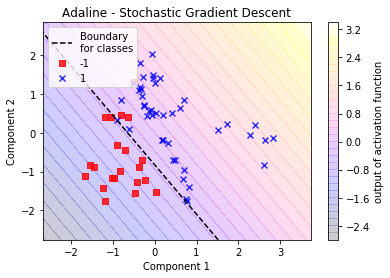

In [23]:
plot_data_and_activation(X_reduced, y_train, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='upper left')